In [ ]:
# Run this line in Colab to install the package if it is
# not already installed.
!pip install git+https://github.com/openai/glide-text2im

In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [1]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.
from PIL import Image
from IPython.display import display
import torch as th
from gita.utils.model_creation import create_model_and_diffusion, model_and_diffusion_defaults, model_and_diffusion_defaults_upsampler
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

/Users/yewon/opt/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
import clip
import torch
# Create base model.
options = model_and_diffusion_defaults()
options.update(num_channels=128, 
               clip_model_name='ViT-B/16',
               timestep_respacing='200',
                )
clip_model, _ = clip.load(options['clip_model_name'])
img_encoder = clip_model.visual
options.update(img_encoder=img_encoder, 
                encoding_dim=img_encoder.output_dim, 
                aug_level=0.07,
                seed=928,
                save_interval=5000,)
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(torch.load('checkpoint/model006000.pt', map_location=device))
print('total base parameters', f'{sum(x.numel() for x in model.parameters() if x.requires_grad):,}')

total base parameters 131,492,486


In [39]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
options_up.update(img_encoder=img_encoder, 
                    encoding_dim=img_encoder.output_dim, 
                    num_channels=64,
                    aug_level=0.07,)
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(torch.load('checkpoint/upsampler/model002000.pt', map_location=device))
print('total upsampler parameters', f"{sum(x.numel() for x in model_up.parameters()):,}")

total upsampler parameters 120,941,382


In [32]:
import copy

def inverse_normalize(batch, mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)):
    """
    :param img: numpy array. shape (C, H, W). [-1~1]
    :return: numpy array. shape (height, width, channel). [0~1]
    """
    img = copy.deepcopy(batch)
    for i in range(3):
        img[:, i,:, :] = ((img[:, i,:,:]) * std[i]) + mean[i]

    return img*255

def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = inverse_normalize(batch, (0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [37]:
from gita.data.teeth_img import PairedTeethImageData
from torch.utils.data import DataLoader

batch_size = 1

data = PairedTeethImageData('/Users/yewon/Library/CloudStorage/OneDrive-연세대학교(YonseiUniversity)/예원/Projects/FTP Translation/dataset/val', 
                            istrain=False)
dataloader = DataLoader(data, batch_size, shuffle=False)

guidance_scale = 2.5
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
# upsample_temp = 0.997

100%|██████████| 200/200 [15:19<00:00,  4.60s/it]


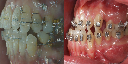

In [38]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
# tokens = model.tokenizer.encode(prompt)
# tokens, mask = model.tokenizer.padded_tokens_and_mask(
#     tokens, options['text_ctx']
# )

# Create the classifier-free guidance tokens (empty)
full_batch_size = batch_size * 2
# uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
#     [], options['text_ctx']
# )

# Pack the tokens together into model kwargs.
# model_kwargs = dict(
#     tokens=th.tensor(
#         [tokens] * batch_size + [uncond_tokens] * batch_size, device=device
#     ),
#     mask=th.tensor(
#         [mask] * batch_size + [uncond_mask] * batch_size,
#         dtype=th.bool,
#         device=device,
#     ),
# )

# Create a classifier-free guidance sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

# Sample from the base model.
# model.del_cache()
for i, (batch, cond) in enumerate(dataloader):
    cond['condi_img'] = torch.concat([cond['condi_img'], torch.zeros_like(cond['condi_img'])], dim=0)
    samples = diffusion.p_sample_loop(
        model_fn,
        (full_batch_size, 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=cond,
        cond_fn=None,
        denoised_fn=dynamic_thr
    )[:batch_size]
    gt = batch
    condi = cond['condi_img']
    break
# model.del_cache()
out = torch.concat([samples, gt], axis=3)
# Show the output
show_images(out)

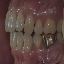

In [25]:
show_images(batch)

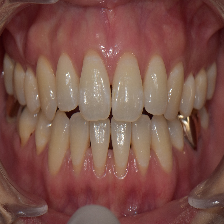

In [40]:
show_images(cond['condi_img'])

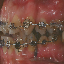

In [9]:
show_images(samples)

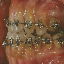

In [7]:
show_images(samples)

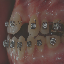

In [20]:
show_images(samples)

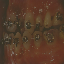

In [18]:
show_images(samples)

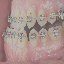

In [16]:
show_images(samples)

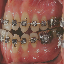

In [35]:
show_images(samples)

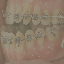

In [39]:
show_images(kwargs['low_res'])

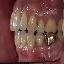

In [13]:
show_images(batch)

In [41]:
condi = condi[0:1, ...]
print(condi.shape)

torch.Size([1, 3, 224, 224])


In [16]:
import torch

def dynamic_thr(x:torch.Tensor, p=0.95, **kwargs):
    def right_pad_dims_to(x, t):
        padding_dims = x.ndim - t.ndim
        if padding_dims <= 0:
            return t
        return t.view(*t.shape, *((1,) * padding_dims))
    s = torch.quantile(x.reshape(x.shape[0], -1).abs(), p, dim=-1)
    s.clamp_(min=1.0)
    s = right_pad_dims_to(x, s)
    return x.clamp(-s, s) / s
# Create a classifier-free guidance sampling function
def model_up_fn(x_t, ts, **kwargs):
    half = x_t[: len(x_t) // 2]
    combined = th.cat([half, half], dim=0)
    model_out = model_up(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps, uncond_eps = th.split(eps, len(eps) // 2, dim=0)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps, half_eps], dim=0)
    return th.cat([eps, rest], dim=1)

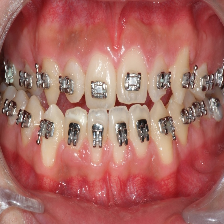

In [47]:
show_images(condi)

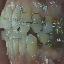

In [45]:
show_images(samples)

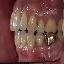

In [43]:
show_images(batch)

100%|██████████| 27/27 [01:36<00:00,  3.58s/it]


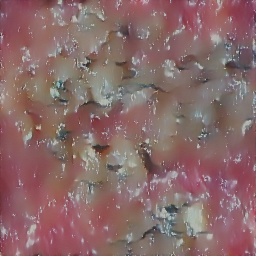

In [46]:
from torchvision.transforms import Compose, Normalize, Resize
from gita.data.teeth_img import GaussianNoise
##############################
# Upsample the 64x64 samples #
##############################
from clip.clip import BICUBIC

up_shape = (batch_size, 3, 256, 256)
preprocess = Compose([Resize((64, 64),interpolation=BICUBIC), 
                      Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))])

# diffusion_up.
kwargs = {'low_res':samples, 
          'condi_img':condi}
up_samples = diffusion_up.ddim_sample_loop(
    model_up,
    up_shape,
    noise=th.randn(up_shape, device=device) * 0.997,
    device=device,
    clip_denoised=True,
    progress=True,
    model_kwargs=kwargs,
    denoised_fn=dynamic_thr,
    )[:batch_size]

# Show the output
show_images(up_samples)

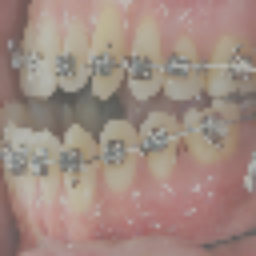

In [44]:
import torch.nn.functional as F

biup = F.interpolate(samples, (256, 256), mode="bilinear")
show_images(biup)

In [7]:
data = PairedTeethImageData('/Users/yewon/Library/CloudStorage/OneDrive-연세대학교(YonseiUniversity)/예원/Projects/FTP Translation/dataset/val', 
                            istrain=False,
                            super_res=True,
                            img_size=256,
                            low_res_size=64)
dataloader = DataLoader(data, batch_size, shuffle=False)
for batch, cond in dataloader:
    low_res = cond['low_res']
    # up_samples = diffusion_up.ddim_sample_loop(
    #                     model_up,
    #                     up_shape,
    #                     noise=th.randn(up_shape, device=device) * 0.997,
    #                     device=device,
    #                     clip_denoised=True,
    #                     progress=True,
    #                     model_kwargs=cond,
    #                     denoised_fn=dynamic_thr,)[:batch_size]
    break

# show_images(up_samples)

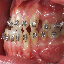

In [8]:
show_images(low_res)